## Four seasons time series plots

### Goals:
* Create time series of various fields compared to obs (ERA5)

### Requirements:
* Unlike other notebooks here, this requires loading e3sm_unified environment and using that kernel. 

* Example of required libraries are xcdat, cdutil, genutil, MV2

### Getting running
First, you will want to access a jupyter notebook on perlmutter by accessing https://jupyter.nersc.gov/

Before you can start running this notebook, you will need to set up your environment.
1) Open up a ssh terminal on perlmutter and then load e3sm_unified:
``` source /global/common/software/e3sm/anaconda_envs/load_latest_e3sm_unified_pm-cpu.sh ```

2) Then create an ipython kernel with the environment:
``` python -m ipykernel install --user --name latest_e3sm_unified --display-name latest_e3sm_unified ```

When you open this notebook, you will then want to make sure you load `latest_e3sm_unified`, as indicated on the top right of the window. 



In [1]:
import matplotlib.pyplot as plt

In [2]:
import cdms2
import cdutil
import genutil
import numpy as np
import pylab as pl
cdms2.setAutoBounds(1)
#import xarray

import xcdat

import MV2

In [3]:
import cftime

### Load necessary datasets, land masks, and area weights

In [4]:
# Load SCREAMv1 regridded files with the Vert Int output
directory_prefix='/global/cfs/cdirs/e3sm/terai/SCREAM/v1_production'
f_Jan_VertIntegrals=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_DY2/output.scream.VertIntegrals.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)
f_Apr_VertIntegrals=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_Apr2013/output.scream.VertIntegrals.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)
f_Aug_VertIntegrals=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_DY1/output.scream.VertIntegrals.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)
f_Oct_VertIntegrals=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_40dayrun/output.scream.VertIntegrals.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)


In [5]:
# Load CERES (obs) datasets
directory_prefix='/global/cfs/cdirs/e3sm/terai/Obs_datasets/ERA5/'
f_Jan_ERA5=xcdat.open_dataset(directory_prefix+'ERA5_surf_20200101_20200229.nc', add_bounds=True)
f_Apr_ERA5=xcdat.open_dataset(directory_prefix+'ERA5_humidity_20130401_20130530.nc', add_bounds=True)
f_Aug_ERA5=xcdat.open_dataset(directory_prefix+'ERA5_humidity_20160801_20160930.nc', add_bounds=True)
f_Oct_ERA5=xcdat.open_dataset(directory_prefix+'ERA5_humidity_20131001_20131130.nc', add_bounds=True)

In [6]:
# Load SCREAMv0 regridded data with integrated water variables
directory_prefix='/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/regridded/'
f_v0_Jan_h0=xcdat.open_mfdataset(directory_prefix+'/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h0.*nc', add_bounds=True, parallel=True, drop_variables=('P3_input_dim', 'P3_output_dim'))

In [8]:
import xarray
# Get masks for SCREAMv1 and ERA5
# Load land fraction with 721x1440 grid
directory_prefix='/global/cfs/cdirs/e3sm/terai/land_file/'
f_ERA5_landfrac=xarray.open_dataset(directory_prefix+'rgr_721x1440_USGS-gtopo30_ne1024np4pg2_x6t-SGH.c20210614.nc')
# Specify land mask (mask out ocean)
land_only_mask=xarray.where(f_ERA5_landfrac.LANDFRAC>0.5,1,np.nan)
ERA5_land_only_mask=land_only_mask.copy(deep=True)
ERA5_land_only_mask=ERA5_land_only_mask.rename({'lat':'latitude','lon':'longitude'}) # make the x-y dimension names consistent with ERA5

# Load land fraction with 256x512 grid
directory_prefix='/global/cfs/cdirs/e3sm/terai/land_file/'
f_landfrac_v1=xarray.open_dataset(directory_prefix+'rgr_256x512_USGS-gtopo30_ne1024np4pg2_x6t-SGH.c20210614.nc')
# Specify land mask for regridded v1 data (mask out ocean)
land_only_mask_v1=xarray.where(f_landfrac_v1.LANDFRAC>0.5,1,np.nan)

In [16]:
# Get weights for v1 and for ERA5
v1_weights=f_Apr_VertIntegrals["area"]
ERA5_weights=f_ERA5_landfrac["area"]
ERA5_weights=ERA5_weights.rename({'lat':'latitude','lon':'longitude'}) # make the x-y dimension names consistent with ERA5

#### Function to do spatial averaging after specifying latitude band and whether to use land mask or not

In [11]:
def calc_timeseries(filehandle,varname,time1,time2,mask=None,maskname=None,coeff=1.,lat_max=90.,lat_min=-90.,varweights=None):
    if mask is not None:  #if masks are provided, create a new variable with masked output
        print('Masking data')
        filehandle['mask']=mask
        filehandle[varname+maskname]=filehandle[varname].where(mask>0,drop=True)
        varname=varname+maskname
    if varweights is not None:  #if weights are provided, use them for spatial averaging
        print('using weights')
        # Calculate spatial average 
        timeseries_var_dataarray=filehandle.spatial.average(varname, lat_bounds=(lat_min,lat_max),axis="XY",weights=varweights)[varname].sel(time=slice(time1, time2))
    else:
        # Calculate spatial average without specified weights (xcdat will infer weights based on lat_bnds, lon_bnds, or area variable in dataset)
        timeseries_var_dataarray=filehandle.spatial.average(varname, lat_bounds=(lat_min,lat_max),axis="XY")[varname].sel(time=slice(time1, time2))
    timeseries_var_output=np.array(timeseries_var_dataarray)*coeff   #coeff is there in case you need to scale raw output to match units (e.g., precip rate)
    # Get the time variable output
    timeseries_time=filehandle.sel(time=slice(time1, time2)).indexes['time'].to_datetimeindex()
    return timeseries_var_output,timeseries_time

### Calculate global mean water vapor path

In [14]:
# Calculate global mean water vapor path values (use default lat_max=90.,lat_min=-90. and no mask)
glb_mean_WaterVaporPath_v1_Jan,time_v1_Jan=calc_timeseries(f_Jan_VertIntegrals,"VapWaterPath",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_WaterVaporPath_v1_Apr,time_v1_Apr=calc_timeseries(f_Apr_VertIntegrals,"VapWaterPath",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_WaterVaporPath_v1_Aug,time_v1_Aug=calc_timeseries(f_Aug_VertIntegrals,"VapWaterPath",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_WaterVaporPath_v1_Oct,time_v1_Oct=calc_timeseries(f_Oct_VertIntegrals,"VapWaterPath",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=1.,varweights=v1_weights)


using weights
using weights
using weights
using weights


In [17]:
# Calculate global mean water vapor path values (use default lat_max=90.,lat_min=-90. and no mask)
# Same as above but for ERA5
glb_mean_WaterVaporPath_ERA5_Jan,time_ERA5_Jan=calc_timeseries(f_Jan_ERA5,"tcwv",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_WaterVaporPath_ERA5_Apr,time_ERA5_Apr=calc_timeseries(f_Apr_ERA5,"tcwv",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_WaterVaporPath_ERA5_Aug,time_ERA5_Aug=calc_timeseries(f_Aug_ERA5,"tcwv",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_WaterVaporPath_ERA5_Oct,time_ERA5_Oct=calc_timeseries(f_Oct_ERA5,"tcwv",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=1.,varweights=ERA5_weights)


using weights
using weights
using weights
using weights


In [18]:
# Same as above but for v0 DYAMOND2 sim
glb_mean_WaterVaporPath_v0_Jan,time_v0_Jan=calc_timeseries(f_v0_Jan_h0,"TMQ",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=v1_weights)


using weights


/tmp/ipykernel_172778/880204395.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  timeseries_time=filehandle.sel(time=slice(time1, time2)).indexes['time'].to_datetimeindex()


### Check to see if values look as expected

In [19]:
# Following helps to make the dates on time series more concise
import matplotlib.dates as mdates
import matplotlib.units as munits
import datetime
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

(22.5, 27.75)

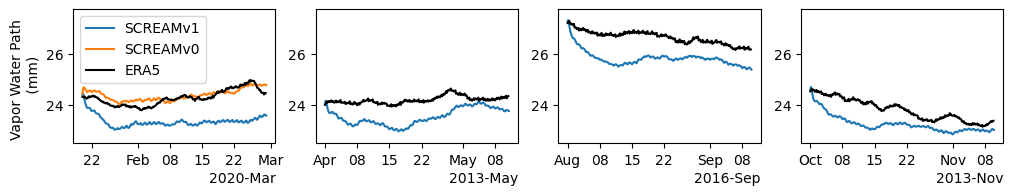

In [20]:
fig=plt.figure(figsize=(12,8))
axs=fig.add_subplot(4,4,1)
plt.plot(time_v1_Jan,glb_mean_WaterVaporPath_v1_Jan,label='SCREAMv1')
plt.plot(time_v0_Jan,glb_mean_WaterVaporPath_v0_Jan,label='SCREAMv0')
plt.plot(time_ERA5_Jan,glb_mean_WaterVaporPath_ERA5_Jan,color='black',label='ERA5')
plt.ylim((22.5,27.75))
plt.ylabel('Vapor Water Path \n (mm)')
plt.legend(loc='upper left',fontsize=10)

axs=fig.add_subplot(4,4,2)
plt.plot(time_v1_Apr,glb_mean_WaterVaporPath_v1_Apr)
plt.plot(time_ERA5_Apr,glb_mean_WaterVaporPath_ERA5_Apr,color='black')
plt.ylim((22.5,27.75))

axs=fig.add_subplot(4,4,3)
plt.plot(time_v1_Aug,glb_mean_WaterVaporPath_v1_Aug)
plt.plot(time_ERA5_Aug,glb_mean_WaterVaporPath_ERA5_Aug,color='black')
plt.ylim((22.5,27.75))

axs=fig.add_subplot(4,4,4)
plt.plot(time_v1_Oct,glb_mean_WaterVaporPath_v1_Oct)
plt.plot(time_ERA5_Oct,glb_mean_WaterVaporPath_ERA5_Oct,color='black')
plt.ylim((22.5,27.75))


### Do the same for T2m, precipitation rate, and 10m wind speed

#### Load necessary datasets for calculating these

In [21]:
# Load SCREAMv1 regridded files with the Surface related output
directory_prefix='/global/cfs/cdirs/e3sm/terai/SCREAM/v1_production'
f_Jan_SurfVars=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_DY2/output.scream.SurfVars.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)
f_Apr_SurfVars=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_Apr2013/output.scream.SurfVars.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)
f_Aug_SurfVars=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_DY1/output.scream.SurfVars.INSTANT.nmins_x15.20*nc', add_bounds=True, parallel=True)
f_Oct_SurfVars=xcdat.open_mfdataset(directory_prefix+'/ne1024pg2_ne1024pg2_40dayrun/output.scream.SurfVars.INSTANT.nmins_x15.20*nc', add_bounds=True)


In [22]:
# Load SCREAMv0 regridded files for this
directory_prefix='/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/regridded/'
f_v0_Jan_h1=xcdat.open_mfdataset(directory_prefix+'/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h1.*nc', add_bounds=True, parallel=True, drop_variables=('P3_input_dim', 'P3_output_dim'))


#### Calculate global mean T 2m

In [23]:
# Calculate global mean T_2m values (use default lat_max=90.,lat_min=-90. and no mask)
glb_mean_T_2m_v1_Jan,time_v1_Jan=calc_timeseries(f_Jan_SurfVars,"T_2m",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_T_2m_v1_Apr,time_v1_Apr=calc_timeseries(f_Apr_SurfVars,"T_2m",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_T_2m_v1_Aug,time_v1_Aug=calc_timeseries(f_Aug_SurfVars,"T_2m",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_T_2m_v1_Oct,time_v1_Oct=calc_timeseries(f_Oct_SurfVars,"T_2m",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=1.,varweights=v1_weights)


using weights
using weights
using weights
using weights


In [24]:
# Calculate global mean water vapor path values (use default lat_max=90.,lat_min=-90. and no mask)
# Same as above but for ERA5
glb_mean_T_2m_ERA5_Jan,time_ERA5_Jan=calc_timeseries(f_Jan_ERA5,"t2m",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_T_2m_ERA5_Apr,time_ERA5_Apr=calc_timeseries(f_Apr_ERA5,"t2m",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_T_2m_ERA5_Aug,time_ERA5_Aug=calc_timeseries(f_Aug_ERA5,"t2m",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_T_2m_ERA5_Oct,time_ERA5_Oct=calc_timeseries(f_Oct_ERA5,"t2m",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=1.,varweights=ERA5_weights)


using weights
using weights
using weights
using weights


In [32]:
# Same as above but for v0 DYAMOND2 sim
glb_mean_T_2m_v0_Jan,time_v0_Jan=calc_timeseries(f_v0_Jan_h1,"TREFHT",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=v1_weights)


using weights


/tmp/ipykernel_172778/880204395.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  timeseries_time=filehandle.sel(time=slice(time1, time2)).indexes['time'].to_datetimeindex()


#### Calculate global mean precipitation rate

In [25]:
# Create variable with total precip from liq and ice surface masses
f_Jan_SurfVars["precip_tot_surf_mass"]=f_Jan_SurfVars["precip_liq_surf_mass"]+f_Jan_SurfVars["precip_ice_surf_mass"]
f_Apr_SurfVars["precip_tot_surf_mass"]=f_Apr_SurfVars["precip_liq_surf_mass"]+f_Apr_SurfVars["precip_ice_surf_mass"]
f_Aug_SurfVars["precip_tot_surf_mass"]=f_Aug_SurfVars["precip_liq_surf_mass"]+f_Aug_SurfVars["precip_ice_surf_mass"]
f_Oct_SurfVars["precip_tot_surf_mass"]=f_Oct_SurfVars["precip_liq_surf_mass"]+f_Oct_SurfVars["precip_ice_surf_mass"]

In [26]:
# Calculate global mean precip values (use default lat_max=90.,lat_min=-90. and no mask)
glb_mean_precip_v1_Jan,time_v1_Jan=calc_timeseries(f_Jan_SurfVars,"precip_tot_surf_mass",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=3600./100.*24.,varweights=v1_weights)
glb_mean_precip_v1_Apr,time_v1_Apr=calc_timeseries(f_Apr_SurfVars,"precip_tot_surf_mass",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=3600./100.*24.,varweights=v1_weights)
glb_mean_precip_v1_Aug,time_v1_Aug=calc_timeseries(f_Aug_SurfVars,"precip_tot_surf_mass",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=3600./100.*24.,varweights=v1_weights)
glb_mean_precip_v1_Oct,time_v1_Oct=calc_timeseries(f_Oct_SurfVars,"precip_tot_surf_mass",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=3600./100.*24.,varweights=v1_weights)


using weights
using weights
using weights
using weights


In [27]:
# Same as above but for ERA5
glb_mean_precip_ERA5_Jan,time_ERA5_Jan=calc_timeseries(f_Jan_ERA5,"mtpr",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=3600.*24.,varweights=ERA5_weights)
glb_mean_precip_ERA5_Apr,time_ERA5_Apr=calc_timeseries(f_Apr_ERA5,"mtpr",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=3600.*24.,varweights=ERA5_weights)
glb_mean_precip_ERA5_Aug,time_ERA5_Aug=calc_timeseries(f_Aug_ERA5,"mtpr",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=3600.*24.,varweights=ERA5_weights)
glb_mean_precip_ERA5_Oct,time_ERA5_Oct=calc_timeseries(f_Oct_ERA5,"mtpr",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=3600.*24.,varweights=ERA5_weights)


using weights
using weights
using weights
using weights


In [34]:
# Same as above but for SCREAMv0
glb_mean_precip_v0_Jan,time_v0_Jan=calc_timeseries(f_v0_Jan_h1,"PRECT",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=3600.*24.*1000.,varweights=v1_weights)

using weights


/tmp/ipykernel_172778/880204395.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  timeseries_time=filehandle.sel(time=slice(time1, time2)).indexes['time'].to_datetimeindex()


#### Calculate global mean 10m wind speed

In [29]:
# Create new var for ERA5 bc U10 and V10 are separated
f_Jan_ERA5["wind_speed_10m"]=(f_Jan_ERA5.u10**2+f_Jan_ERA5.v10**2)**0.5
f_Apr_ERA5["wind_speed_10m"]=(f_Apr_ERA5.u10**2+f_Apr_ERA5.v10**2)**0.5
f_Aug_ERA5["wind_speed_10m"]=(f_Aug_ERA5.u10**2+f_Aug_ERA5.v10**2)**0.5
f_Oct_ERA5["wind_speed_10m"]=(f_Oct_ERA5.u10**2+f_Oct_ERA5.v10**2)**0.5

In [30]:
# Calculate global mean wind_speed_10m values (use default lat_max=90.,lat_min=-90. and no mask)
glb_mean_wind_speed_10m_v1_Jan,time_v1_Jan=calc_timeseries(f_Jan_SurfVars,"wind_speed_10m",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_wind_speed_10m_v1_Apr,time_v1_Apr=calc_timeseries(f_Apr_SurfVars,"wind_speed_10m",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_wind_speed_10m_v1_Aug,time_v1_Aug=calc_timeseries(f_Aug_SurfVars,"wind_speed_10m",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=1.,varweights=v1_weights)
glb_mean_wind_speed_10m_v1_Oct,time_v1_Oct=calc_timeseries(f_Oct_SurfVars,"wind_speed_10m",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=1.,varweights=v1_weights)


using weights
using weights
using weights
using weights


In [31]:
# Same as above but for ERA5
glb_mean_wind_speed_10m_ERA5_Jan,time_ERA5_Jan=calc_timeseries(f_Jan_ERA5,"wind_speed_10m",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_wind_speed_10m_ERA5_Apr,time_ERA5_Apr=calc_timeseries(f_Apr_ERA5,"wind_speed_10m",'2013-04-01 00:00:00','2013-05-10 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_wind_speed_10m_ERA5_Aug,time_ERA5_Aug=calc_timeseries(f_Aug_ERA5,"wind_speed_10m",'2016-08-01 00:00:00','2016-09-09 23:59:59',coeff=1.,varweights=ERA5_weights)
glb_mean_wind_speed_10m_ERA5_Oct,time_ERA5_Oct=calc_timeseries(f_Oct_ERA5,"wind_speed_10m",'2013-10-01 00:00:00','2013-11-09 23:59:59',coeff=1.,varweights=ERA5_weights)


using weights
using weights
using weights
using weights


In [35]:
# Same as above but for v0 DYAMOND2 sim
glb_mean_wind_speed_10m_v0_Jan,time_v0_Jan=calc_timeseries(f_v0_Jan_h1,"WINDSPD_10M",'2020-01-20 00:00:00','2020-02-28 23:59:59',coeff=1.,varweights=v1_weights)

using weights


/tmp/ipykernel_172778/880204395.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  timeseries_time=filehandle.sel(time=slice(time1, time2)).indexes['time'].to_datetimeindex()


(22.5, 27.75)

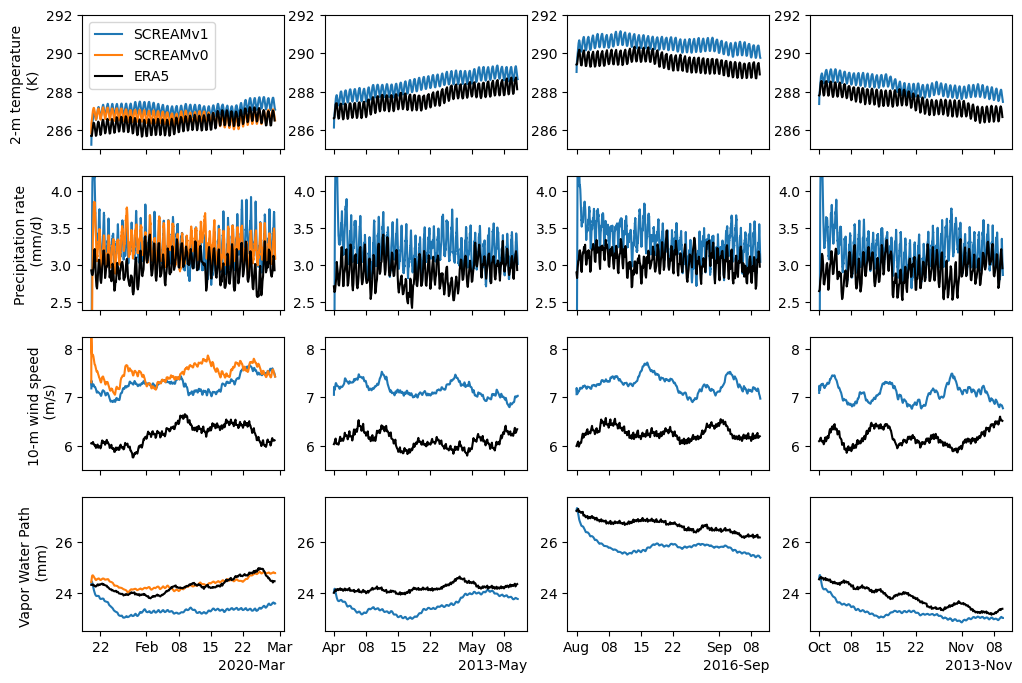

In [45]:
fig=plt.figure(figsize=(12,8))
axs=fig.add_subplot(4,4,1)
plt.plot(time_v1_Jan,glb_mean_T_2m_v1_Jan,label='SCREAMv1')
plt.plot(time_v0_Jan,glb_mean_T_2m_v0_Jan,label='SCREAMv0')
plt.plot(time_ERA5_Jan,glb_mean_T_2m_ERA5_Jan,color='black',label='ERA5')
plt.ylim((285,292))
axs.xaxis.set_tick_params(labelbottom=False)
plt.ylabel('2-m temperature \n (K)')
plt.legend(loc='upper left',fontsize=10)

axs=fig.add_subplot(4,4,2)
plt.plot(time_v1_Apr,glb_mean_T_2m_v1_Apr)
plt.plot(time_ERA5_Apr,glb_mean_T_2m_ERA5_Apr,color='black')
plt.ylim((285,292))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,3)
plt.plot(time_v1_Aug,glb_mean_T_2m_v1_Aug)
plt.plot(time_ERA5_Aug,glb_mean_T_2m_ERA5_Aug,color='black')
plt.ylim((285,292))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,4)
plt.plot(time_v1_Oct,glb_mean_T_2m_v1_Oct)
plt.plot(time_ERA5_Oct,glb_mean_T_2m_ERA5_Oct,color='black')
plt.ylim((285,292))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,5)
plt.plot(time_v1_Jan,glb_mean_precip_v1_Jan,label='SCREAMv1')
plt.plot(time_v0_Jan,glb_mean_precip_v0_Jan,label='SCREAMv0')
plt.plot(time_ERA5_Jan,glb_mean_precip_ERA5_Jan,color='black',label='ERA5')
plt.ylim((2.4,4.2))
axs.xaxis.set_tick_params(labelbottom=False)
plt.ylabel('Precipitation rate \n (mm/d)')
#plt.legend(loc='upper left',fontsize=10)

axs=fig.add_subplot(4,4,6)
plt.plot(time_v1_Apr,glb_mean_precip_v1_Apr)
plt.plot(time_ERA5_Apr,glb_mean_precip_ERA5_Apr,color='black')
plt.ylim((2.4,4.2))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,7)
plt.plot(time_v1_Aug,glb_mean_precip_v1_Aug)
plt.plot(time_ERA5_Aug,glb_mean_precip_ERA5_Aug,color='black')
plt.ylim((2.4,4.2))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,8)
plt.plot(time_v1_Oct,glb_mean_precip_v1_Oct)
plt.plot(time_ERA5_Oct,glb_mean_precip_ERA5_Oct,color='black')
plt.ylim((2.4,4.2))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,9)
plt.plot(time_v1_Jan,glb_mean_wind_speed_10m_v1_Jan,label='SCREAMv1')
plt.plot(time_v0_Jan,glb_mean_wind_speed_10m_v0_Jan,label='SCREAMv0')
plt.plot(time_ERA5_Jan,glb_mean_wind_speed_10m_ERA5_Jan,color='black',label='ERA5')
plt.ylim((5.5,8.25))
axs.xaxis.set_tick_params(labelbottom=False)
plt.ylabel('10-m wind speed \n (m/s)')
#plt.legend(loc='upper left',fontsize=10)

axs=fig.add_subplot(4,4,10)
plt.plot(time_v1_Apr,glb_mean_wind_speed_10m_v1_Apr)
plt.plot(time_ERA5_Apr,glb_mean_wind_speed_10m_ERA5_Apr,color='black')
plt.ylim((5.5,8.25))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,11)
plt.plot(time_v1_Aug,glb_mean_wind_speed_10m_v1_Aug)
plt.plot(time_ERA5_Aug,glb_mean_wind_speed_10m_ERA5_Aug,color='black')
plt.ylim((5.5,8.25))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,12)
plt.plot(time_v1_Oct,glb_mean_wind_speed_10m_v1_Oct)
plt.plot(time_ERA5_Oct,glb_mean_wind_speed_10m_ERA5_Oct,color='black')
plt.ylim((5.5,8.25))
axs.xaxis.set_tick_params(labelbottom=False)

axs=fig.add_subplot(4,4,13)
plt.plot(time_v1_Jan,glb_mean_WaterVaporPath_v1_Jan,label='SCREAMv1')
plt.plot(time_v0_Jan,glb_mean_WaterVaporPath_v0_Jan,label='SCREAMv0')
plt.plot(time_ERA5_Jan,glb_mean_WaterVaporPath_ERA5_Jan,color='black',label='ERA5')
plt.ylim((22.5,27.75))
plt.ylabel('Vapor Water Path \n (mm)')
#plt.legend(loc='upper left',fontsize=10)

axs=fig.add_subplot(4,4,14)
plt.plot(time_v1_Apr,glb_mean_WaterVaporPath_v1_Apr)
plt.plot(time_ERA5_Apr,glb_mean_WaterVaporPath_ERA5_Apr,color='black')
plt.ylim((22.5,27.75))

axs=fig.add_subplot(4,4,15)
plt.plot(time_v1_Aug,glb_mean_WaterVaporPath_v1_Aug)
plt.plot(time_ERA5_Aug,glb_mean_WaterVaporPath_ERA5_Aug,color='black')
plt.ylim((22.5,27.75))

axs=fig.add_subplot(4,4,16)
plt.plot(time_v1_Oct,glb_mean_WaterVaporPath_v1_Oct)
plt.plot(time_ERA5_Oct,glb_mean_WaterVaporPath_ERA5_Oct,color='black')
plt.ylim((22.5,27.75))

### Example of masking over land and specifying a latitude band
* Example shows T_2m over 30N-50N over land

In [48]:
glb_mean_T_2m_30N50Nlnd_v1_Jan,time_v1_Jan=calc_timeseries(f_Jan_SurfVars,"T_2m",'2020-01-20 00:00:00','2020-02-28 23:59:59',mask=land_only_mask_v1,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=v1_weights)
glb_mean_T_2m_30N50Nlnd_v1_Apr,time_v1_Apr=calc_timeseries(f_Apr_SurfVars,"T_2m",'2013-04-01 00:00:00','2013-05-10 23:59:59',mask=land_only_mask_v1,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=v1_weights)
glb_mean_T_2m_30N50Nlnd_v1_Aug,time_v1_Aug=calc_timeseries(f_Aug_SurfVars,"T_2m",'2016-08-01 00:00:00','2016-09-09 23:59:59',mask=land_only_mask_v1,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=v1_weights)
glb_mean_T_2m_30N50Nlnd_v1_Oct,time_v1_Oct=calc_timeseries(f_Oct_SurfVars,"T_2m",'2013-10-01 00:00:00','2013-11-09 23:59:59',mask=land_only_mask_v1,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=v1_weights)

Masking data
using weights
Masking data
using weights
Masking data
using weights
Masking data
using weights


In [49]:
glb_mean_T_2m_30N50Nlnd_ERA5_Jan,time_ERA5_Jan=calc_timeseries(f_Jan_ERA5,"t2m",'2020-01-20 00:00:00','2020-02-28 23:59:59',mask=ERA5_land_only_mask,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=ERA5_weights)
glb_mean_T_2m_30N50Nlnd_ERA5_Apr,time_ERA5_Apr=calc_timeseries(f_Apr_ERA5,"t2m",'2013-04-01 00:00:00','2013-05-10 23:59:59',mask=ERA5_land_only_mask,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=ERA5_weights)
glb_mean_T_2m_30N50Nlnd_ERA5_Aug,time_ERA5_Aug=calc_timeseries(f_Aug_ERA5,"t2m",'2016-08-01 00:00:00','2016-09-09 23:59:59',mask=ERA5_land_only_mask,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=ERA5_weights)
glb_mean_T_2m_30N50Nlnd_ERA5_Oct,time_ERA5_Oct=calc_timeseries(f_Oct_ERA5,"t2m",'2013-10-01 00:00:00','2013-11-09 23:59:59',mask=ERA5_land_only_mask,maskname='_lnd',coeff=1.,lat_max=50.,lat_min=30.,varweights=ERA5_weights)

Masking data
using weights
Masking data
using weights
Masking data
using weights
Masking data
using weights


(275.5, 293.0)

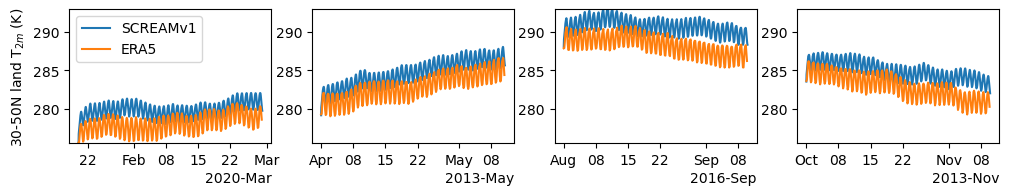

In [50]:
fig=plt.figure(figsize=(12,8))
axs=fig.add_subplot(4,4,1)
plt.plot(time_v1_Jan,glb_mean_T_2m_lnd_v1_Jan,label='SCREAMv1')
plt.plot(time_ERA5_Jan,glb_mean_T_2m_30N50Nlnd_ERA5_Jan,label='ERA5')
#plt.plot(f_v0_Jan_h0.indexes['time'].to_datetimeindex()[:-96],glb_mean_T_2m_30N50Nlnd_v0_Jan,label='SCREAMv0')
plt.ylim((275.5,293))
plt.ylabel('30-50N land T$_{2m}$ (K)')
plt.legend(loc='upper left',fontsize=10)

axs=fig.add_subplot(4,4,2)
plt.plot(time_v1_Apr,glb_mean_T_2m_30N50Nlnd_v1_Apr)
plt.plot(time_ERA5_Apr,glb_mean_T_2m_30N50Nlnd_ERA5_Apr)
plt.ylim((275.5,293))

axs=fig.add_subplot(4,4,3)
plt.plot(time_v1_Aug,glb_mean_T_2m_30N50Nlnd_v1_Aug)
plt.plot(time_ERA5_Aug,glb_mean_T_2m_30N50Nlnd_ERA5_Aug)
plt.ylim((275.5,293))

axs=fig.add_subplot(4,4,4)
plt.plot(time_v1_Oct,glb_mean_T_2m_30N50Nlnd_v1_Oct)
plt.plot(time_ERA5_Oct,glb_mean_T_2m_30N50Nlnd_ERA5_Oct)
plt.ylim((275.5,293))
